# Store Sales

## Problem Statement

Corporación Favorita, an Ecuadorian grocery retailer, faces challenges in accurately forecasting unit sales across its stores, leading to overstocking or understocking and resulting in increased food waste and decreased customer satisfaction. To address this, we will develop a machine learning model to predict daily unit sales at less than 0.5 RMSE by average. Utilizing historical sales data, store metadata, promotional information, oil prices, and holiday events, we aim to deliver a robust forecasting model within 4 weeks.

## Imports

In [134]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_log_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor


import xgboost as xgb
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

from keras.models import Sequential
from keras.layers import Dense, LSTM

In [135]:
plot_params={
    'color': '0.75',
    'style': '.-',
    'markeredgecolor': '0.25',
    'markerfacecolor': '0.25',
    'legend': False
}

In [86]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots(figsize=(14,4))
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [3]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method
    
    def fit(self, X_1, X_2, y):
        self.model_1.fit(X_1, y)

        y_fit = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index, columns=y.columns,
        )

        y_resid = y - y_fit
        y_resid = y_resid.stack().squeeze() # wide to long
        self.model_2.fit(X_2, y_resid)

        self.y_columns = y.columns
        self.y_fit = y_fit
        self.y_resid = y_resid
        
    def predict(self, X_1, X_2):
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index, columns=self.y_columns,
        )
        y_pred = y_pred.stack().squeeze()  # wide to long

        y_pred += self.model_2.predict(X_2)

        return y_pred.unstack()  # long to wide


## Import data

In [308]:
store_sales = pd.read_csv(
    'data/train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

/var/folders/xk/5gx1tq55563djqn2f91dfp040000gn/T/ipykernel_7123/1809697030.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  store_sales = pd.read_csv(


In [309]:
holidays_events = pd.read_csv("data/holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')


/var/folders/xk/5gx1tq55563djqn2f91dfp040000gn/T/ipykernel_7123/3989620188.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  holidays_events = pd.read_csv("data/holidays_events.csv",


In [310]:
train = pd.read_csv('data/train_combined.csv', index_col=0)
test = pd.read_csv('data/test_combined.csv', index_col=0)

/var/folders/xk/5gx1tq55563djqn2f91dfp040000gn/T/ipykernel_7123/3869608988.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('data/train_combined.csv', index_col=0)


In [311]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

## Data PreprocessingKNeighborsRegressor

In [313]:
# Add an indicator to distinguish between train and test
train['dataset'] = 'train'
test['dataset'] = 'test'

# Combine the datasets
combined = pd.concat([train, test], axis=0)

### Check for missing and unexpected values 

In [314]:
combined.isnull().sum()

id                         0
date                       0
store_nbr                  0
family                     0
sales                  28512
onpromotion                0
daily_oil_price            0
holiday_type               0
holiday_locale             0
locale_name                0
holiday_description        0
holiday_transferred        0
city                       0
state                      0
store_type                 0
store_cluster              0
day_of_week                0
month                      0
quarter                    0
dataset                    0
dtype: int64

In [315]:
categorical_columns = ['family', 'holiday_type', 'holiday_locale', 'locale_name', 'holiday_transferred', 'city', 'state', 'store_type', 'store_cluster', 'day_of_week', 'month', 'quarter']

In [316]:
# Check unique values
for col in categorical_columns:
    print(f"{col} unique values: ", combined[col].unique())

family unique values:  ['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']
holiday_type unique values:  ['Holiday' 'none' 'Work Day' 'Additional' 'Event' 'Transfer' 'Bridge']
holiday_locale unique values:  ['National' 'none' 'Local' 'Regional']
locale_name unique values:  ['Ecuador' 'none' 'Manta' 'Cotopaxi' 'Cuenca' 'Libertad' 'Riobamba' 'Puyo'
 'Guaranda' 'Imbabura' 'Machala' 'Latacunga' 'El Carmen' 'Santo Domingo'
 'Cayambe' 'Guayaquil' 'Esmeraldas' 'Ambato' 'Ibarra' 'Quevedo'
 'Santo Domingo de los Tsachilas' 'Santa Elena' 'Quito' 'Loja' 'Salinas']
holiday_transferred unique valu

In [317]:
combined['holiday_transferred'].replace({False: 'False'}, inplace=True)

/var/folders/xk/5gx1tq55563djqn2f91dfp040000gn/T/ipykernel_7123/3342495674.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined['holiday_transferred'].replace({False: 'False'}, inplace=True)


In [318]:
combined['holiday_transferred'].unique()

array(['False', 'none', 'True'], dtype=object)

### Encoding variables

In [319]:
categorical_columns

['family',
 'holiday_type',
 'holiday_locale',
 'locale_name',
 'holiday_transferred',
 'city',
 'state',
 'store_type',
 'store_cluster',
 'day_of_week',
 'month',
 'quarter']

In [320]:
combined = pd.get_dummies(combined, columns=categorical_columns, drop_first=True)
print(list(combined.columns))

['id', 'date', 'store_nbr', 'sales', 'onpromotion', 'daily_oil_price', 'holiday_description', 'dataset', 'family_BABY CARE', 'family_BEAUTY', 'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY', 'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI', 'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I', 'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I', 'family_HOME AND KITCHEN II', 'family_HOME APPLIANCES', 'family_HOME CARE', 'family_LADIESWEAR', 'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER', 'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE', 'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS', 'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE', 'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD', 'holiday_type_Bridge', 'holiday_type_Event', 'holiday_type_Holiday', 'holiday_type_Transfer', 'holiday_type_Work Day', 'holiday_type_none', 'holiday_locale_National', 'holiday_locale_Regional', 'hol

### Split back into train and test

In [321]:
train_processed = combined[combined['dataset'] == 'train'].drop(columns=['dataset'])
test_processed = combined[combined['dataset'] == 'test'].drop(columns=['dataset'])

In [322]:
train_processed.info(show_counts=True), test_processed.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 3054348 entries, 0 to 3054347
Columns: 150 entries, id to quarter_4
dtypes: bool(143), datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 603.0+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 28512 entries, 0 to 28511
Columns: 150 entries, id to quarter_4
dtypes: bool(143), datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 5.6+ MB


(None, None)

### PCA

In [324]:
X = train_processed.drop(['date','id','store_nbr', 'holiday_description', 'sales'], axis=1)

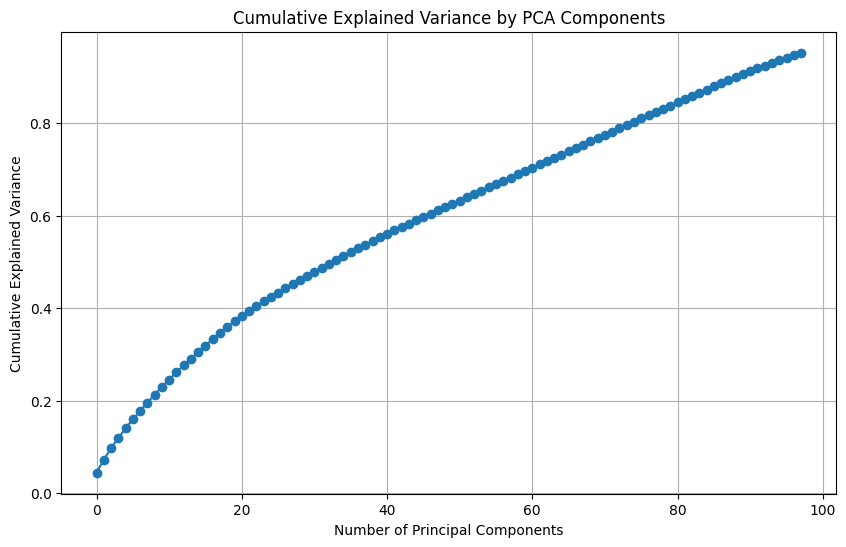

Number of components selected: 98


In [325]:
# Standardize the features before applying PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Adjust as needed

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Plot cumulative explained variance to decide on the number of components
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Optional: Print the number of components selected
print(f"Number of components selected: {X_pca.shape[1]}")


## Modeling

In [336]:
daily_sales_avg = train.groupby('date')['sales'].mean().reset_index()
daily_sales_avg['week'] = daily_sales_avg.date.dt.isocalendar()['week']
daily_sales_avg['day'] = daily_sales_avg.date.dt.dayofweek
daily_sales_avg['date'] = daily_sales_avg.date.dt.to_period('D')
daily_sales_avg = daily_sales_avg.set_index('date')
daily_sales_avg.head()

,sales,week,day
date,,,
2013-01-01,1.409438,1,1
2013-01-02,278.390807,1,2
2013-01-03,202.840197,1,3
2013-01-04,198.911154,1,4
2013-01-05,267.873244,1,5


In [337]:
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc[:, ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)
holidays = holidays[holidays.index.isin(daily_sales_avg.index)]
holidays.head()

,description
date,
2013-01-01,Primer dia del ano
2013-01-05,Recupero puente Navidad
2013-01-12,Recupero puente primer dia del ano
2013-02-11,Carnaval
2013-02-12,Carnaval


In [338]:
family_sales = train.groupby(['family', 'date'])[['sales', 'onpromotion']].mean().unstack('family')
family_sales.index = family_sales.index.to_period('D')

### Linear Regression

#### Linear regression with time series features

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

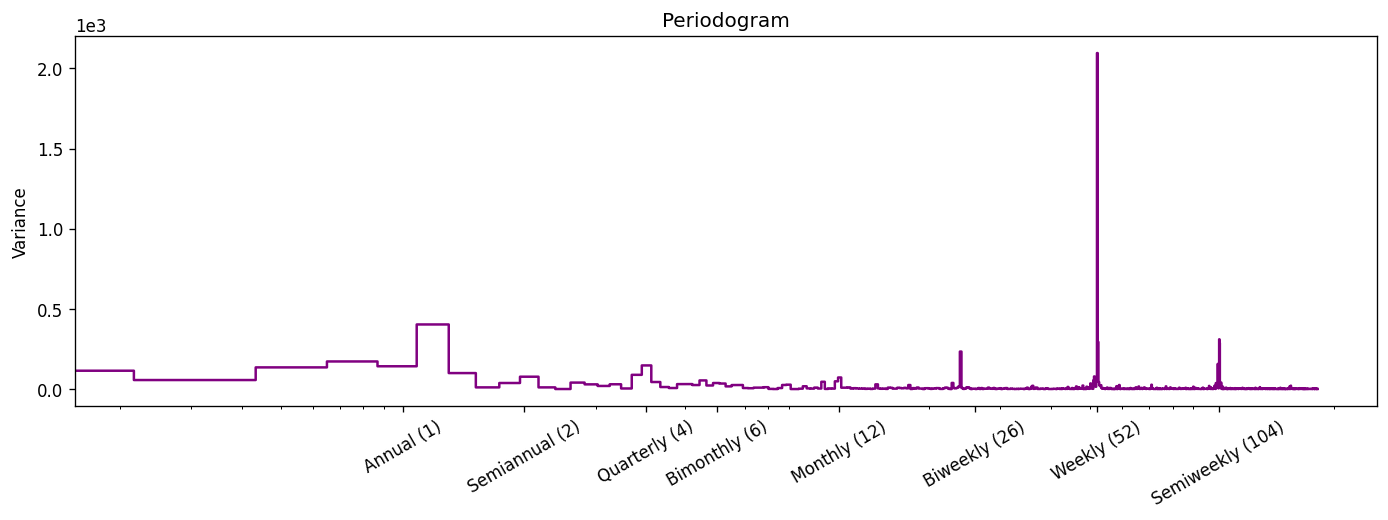

In [355]:
plot_periodogram(daily_sales_avg['sales'])

In [356]:
y= store_sales.unstack(['store_nbr', 'family'])['sales']
y.head()

store_nbr           1                                                \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0   470.652008   
2013-01-03        3.0       0.0    0.0     919.0   0.0   310.654999   
2013-01-04        3.0       0.0    3.0     953.0   0.0   198.365997   
2013-01-05        5.0       0.0    3.0    1160.0   0.0   301.057007   

store_nbr                                           ...         9              \
family     CELEBRATION CLEANING  DAIRY        DELI  ... MAGAZINES       MEATS   
date                                                ...                         
2013-01-01         0.0      0.0    0.0    0.000000  ...       0.0    0.000000   
2013-01-02         0.0   1060.0  579.0  164.069000  ...       0.0  374.531006   
2013-01-03         0.0    836.0  453.0  151.582001  ...       0.0  400.863007   
2013-01-04         0.0    827.0  460.0  131.410995  ...       0.0  310.877991   
2013-01-05         0.0    811.0  464.0  118.612999  ...       0.0  447.684998   

store_nbr                                                                  \
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS     POULTRY   
date                                                                        
2013-01-01           0.0          0.0                     0.0    0.000000   
2013-01-02         482.0          0.0                     0.0  651.291992   
2013-01-03         372.0          0.0                     0.0  509.496002   
2013-01-04         324.0          0.0                     0.0  332.671997   
2013-01-05         461.0          0.0                     0.0  510.919006   

store_nbr                                                                
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES    SEAFOOD  
date                                                                     
2013-01-01            0.0     0.0                        0.0   0.000000  
2013-01-02           83.0     0.0                        0.0  29.214001  
2013-01-03           66.0     0.0                        0.0  25.000000  
2013-01-04           57.0     0.0                        0.0  11.000000  
2013-01-05           84.0     0.0                        0.0  28.361000  

[5 rows x 1782 columns]

In [358]:
holidays_col = pd.get_dummies(holidays)
holidays_col = holidays_col[~holidays_col.index.duplicated(keep='first')]

In [359]:
# order of 12 yearly - for monthly season
fourier = CalendarFourier(freq='YE', order=12)
# order of 2 weekly - for biweekly season
fourier_2 = CalendarFourier(freq='W', order=2)
# order of 4 monthly - for weekly season
fourier_3 = CalendarFourier(freq='ME', order=4)


dp = DeterministicProcess(
    index = y.index, 
    order=3,   #Linear time step for trend
    constant=True,
    seasonal=True,
    additional_terms=[fourier, fourier_2, fourier_3], #Seaonality
    drop=True
)
time_series_cols = dp.in_sample()

In [360]:
X = time_series_cols.join(daily_sales_avg, how='left', on='date').fillna(0.0)
X = X.join(holidays_col, how='left', on='date', validate='one_to_one').fillna(False)
X = X.drop(columns=['sales'])
list(X.columns)

/var/folders/xk/5gx1tq55563djqn2f91dfp040000gn/T/ipykernel_7123/509422395.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.join(holidays_col, how='left', on='date', validate='one_to_one').fillna(False)


['const',
 'trend',
 'trend_squared',
 'trend_cubed',
 's(2,7)',
 's(3,7)',
 's(4,7)',
 's(5,7)',
 's(6,7)',
 's(7,7)',
 'sin(1,freq=YE-DEC)',
 'cos(1,freq=YE-DEC)',
 'sin(2,freq=YE-DEC)',
 'cos(2,freq=YE-DEC)',
 'sin(3,freq=YE-DEC)',
 'cos(3,freq=YE-DEC)',
 'sin(4,freq=YE-DEC)',
 'cos(4,freq=YE-DEC)',
 'sin(5,freq=YE-DEC)',
 'cos(5,freq=YE-DEC)',
 'sin(6,freq=YE-DEC)',
 'cos(6,freq=YE-DEC)',
 'sin(7,freq=YE-DEC)',
 'cos(7,freq=YE-DEC)',
 'sin(8,freq=YE-DEC)',
 'cos(8,freq=YE-DEC)',
 'sin(9,freq=YE-DEC)',
 'cos(9,freq=YE-DEC)',
 'sin(10,freq=YE-DEC)',
 'cos(10,freq=YE-DEC)',
 'sin(11,freq=YE-DEC)',
 'cos(11,freq=YE-DEC)',
 'sin(12,freq=YE-DEC)',
 'cos(12,freq=YE-DEC)',
 'sin(1,freq=W-SUN)',
 'cos(1,freq=W-SUN)',
 'sin(2,freq=W-SUN)',
 'cos(2,freq=W-SUN)',
 'sin(1,freq=ME)',
 'cos(1,freq=ME)',
 'sin(2,freq=ME)',
 'cos(2,freq=ME)',
 'sin(3,freq=ME)',
 'cos(3,freq=ME)',
 'sin(4,freq=ME)',
 'cos(4,freq=ME)',
 'week',
 'day',
 'description_Batalla de Pichincha',
 'description_Black Friday',

In [361]:
y.shape, X.shape

((1684, 1782), (1684, 124))

In [362]:
lg = LinearRegression(fit_intercept=False)
lg.fit(X,y)
y_pred = pd.DataFrame(lg.predict(X), index=X.index, columns=y.columns)
y_pred = y_pred.clip(0.0)

In [363]:
rmsle = root_mean_squared_log_error(y, y_pred)
print(f'RMSLE: {rmsle}')

RMSLE: 0.7742855566331934


#### Hybrid

In [364]:
X_2 = store_sales.unstack(['store_nbr', 'family']).drop('sales', axis=1).stack()  #onpromotion feature

# Label encoding for 'family'
le = LabelEncoder() 
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

# Label encoding for seasonality
X_2["day"] = X_2.index.day 

y.shape, X.shape, X_2.shape

/var/folders/xk/5gx1tq55563djqn2f91dfp040000gn/T/ipykernel_7123/1855701804.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  X_2 = store_sales.unstack(['store_nbr', 'family']).drop('sales', axis=1).stack()  #onpromotion feature


((1684, 1782), (1684, 124), (55572, 56))

In [365]:
model = BoostedHybrid(LinearRegression(), XGBRegressor())

# YOUR CODE HERE: Fit and predict
model.fit(X, X_2, y)
y_pred = model.predict(X, X_2)
y_pred = y_pred.clip(0.0)

/var/folders/xk/5gx1tq55563djqn2f91dfp040000gn/T/ipykernel_7123/1188101093.py:16: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_resid = y_resid.stack().squeeze() # wide to long
/var/folders/xk/5gx1tq55563djqn2f91dfp040000gn/T/ipykernel_7123/1188101093.py:28: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_pred = y_pred.stack().squeeze()  # wide to long


In [366]:
rmsle = root_mean_squared_log_error(y, y_pred)
print(f'RMSLE: {rmsle}')

RMSLE: 0.8855633682399582


In [367]:
model = BoostedHybrid(LinearRegression(), RandomForestRegressor())

# YOUR CODE HERE: Fit and predict
model.fit(X, X_2, y)
y_pred = model.predict(X, X_2)
y_pred = y_pred.clip(0.0)

/var/folders/xk/5gx1tq55563djqn2f91dfp040000gn/T/ipykernel_7123/1188101093.py:16: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_resid = y_resid.stack().squeeze() # wide to long
/var/folders/xk/5gx1tq55563djqn2f91dfp040000gn/T/ipykernel_7123/1188101093.py:28: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_pred = y_pred.stack().squeeze()  # wide to long


In [368]:
rmsle = root_mean_squared_log_error(y, y_pred)
print(f'RMSLE: {rmsle}')

RMSLE: 0.6854515534825145


In [369]:
model = BoostedHybrid(LinearRegression(), KNeighborsRegressor())

# YOUR CODE HERE: Fit and predict
model.fit(X, X_2, y)
y_pred = model.predict(X, X_2)
y_pred = y_pred.clip(0.0)

/var/folders/xk/5gx1tq55563djqn2f91dfp040000gn/T/ipykernel_7123/1188101093.py:16: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_resid = y_resid.stack().squeeze() # wide to long
/var/folders/xk/5gx1tq55563djqn2f91dfp040000gn/T/ipykernel_7123/1188101093.py:28: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_pred = y_pred.stack().squeeze()  # wide to long


In [370]:
rmsle = root_mean_squared_log_error(y, y_pred)
print(f'RMSLE: {rmsle}')

RMSLE: 0.786916475456625


#### Result plot

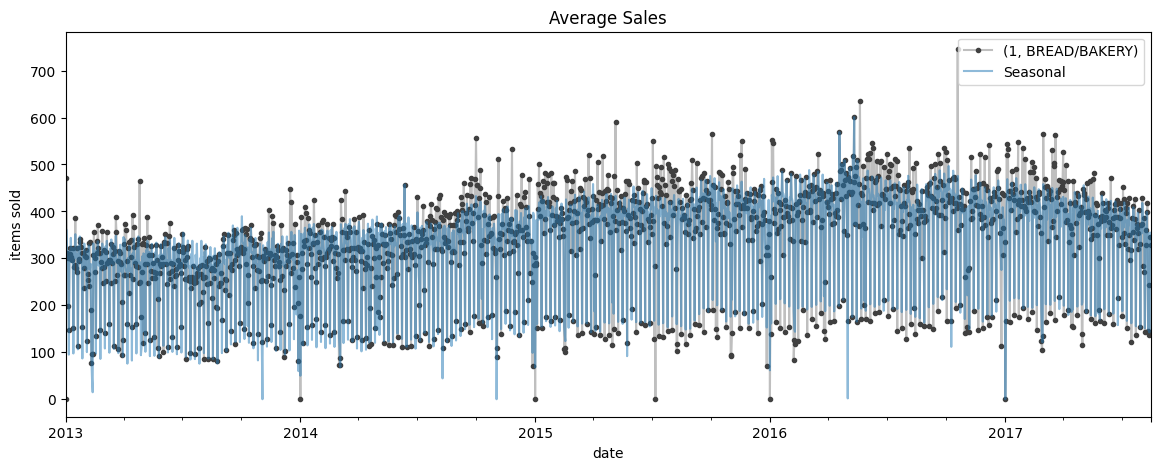

In [210]:
column_name = y_pred.columns[5]
plt.figure(figsize=(14,5))
ax = y[column_name].plot(**plot_params, title="Average Sales", ylabel="items sold")
ax = y_pred[column_name].plot(ax=ax, label="Seasonal",  alpha=0.5)
ax.legend()
plt.show()

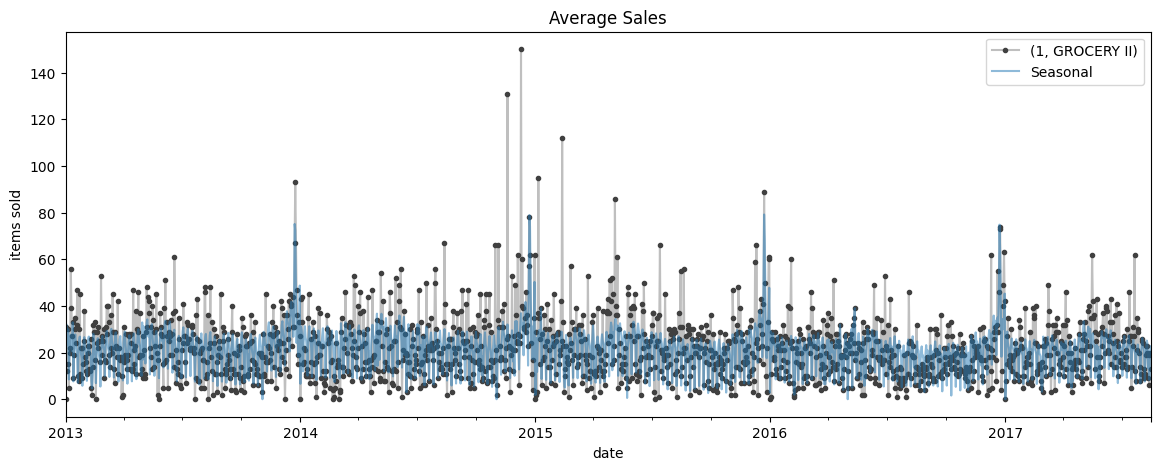

In [211]:
column_name = y_pred.columns[13]
plt.figure(figsize=(14,5))
ax = y[column_name].plot(**plot_params, title="Average Sales", ylabel="items sold")
ax = y_pred[column_name].plot(ax=ax, label="Seasonal",  alpha=0.5)
ax.legend()
plt.show()

### ARIMA

In [371]:
#ARIMA
data = train_processed.groupby('date')['sales'].sum().reset_index().set_index('date')
data = data.asfreq('D')  # Ensure the data is daily
data.head()

,sales
date,
2013-01-01,2511.618999
2013-01-02,496092.417944
2013-01-03,361461.231124
2013-01-04,354459.677093
2013-01-05,477350.121229


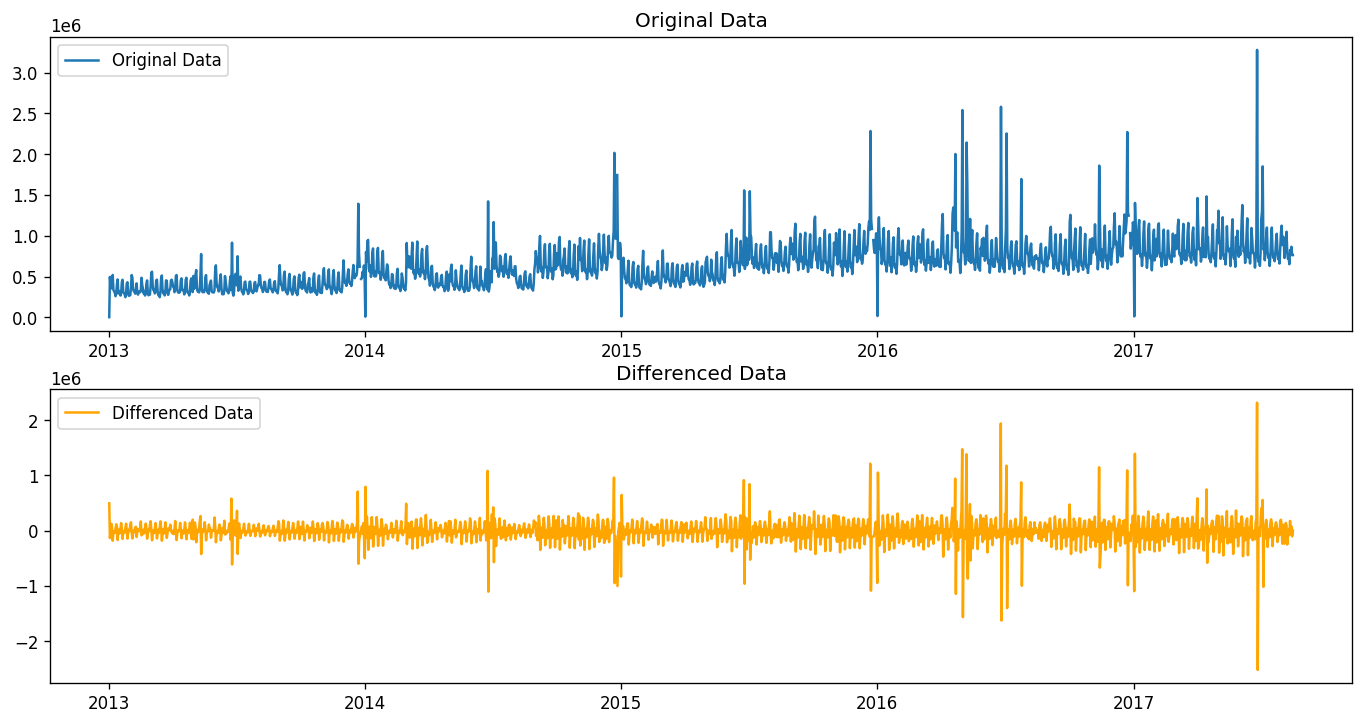

In [372]:
# Differencing to make the data stationary
data_diff = data.diff().dropna()

# Plot original and differenced data
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(data, label='Original Data')
plt.title('Original Data')
plt.legend(loc='best')

plt.subplot(2, 1, 2)
plt.plot(data_diff, label='Differenced Data', color='orange')
plt.title('Differenced Data')
plt.legend(loc='best')
plt.show()

In [373]:
result = adfuller(data_diff.dropna())
print("The p-value for the ADF test is ", result[1])

The p-value for the ADF test is  1.0169866521750168e-18


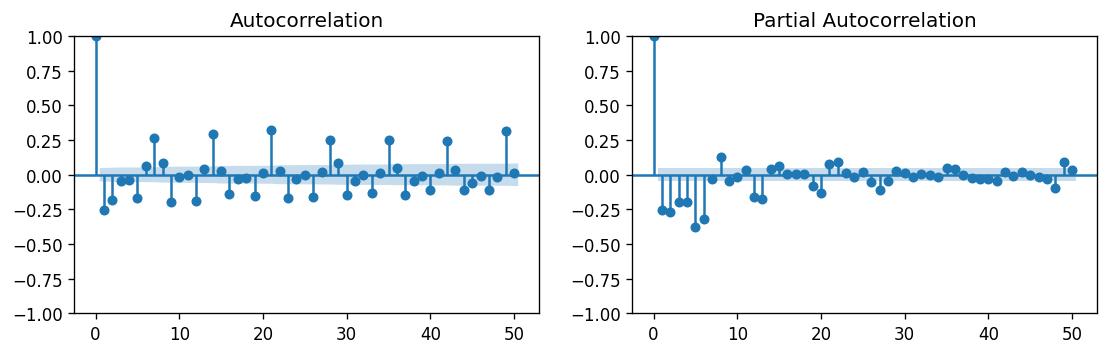

In [374]:
fig, axes = plt.subplots(1,2, figsize=(11, 3))

# Plot the ACF
plot_acf(data_diff, lags=50, ax=axes[0])
# Plot the PACF
plot_pacf(data_diff, lags=50, ax=axes[1])
plt.show()

In [376]:
split_point = int(len(data) * 0.8)

# Split the data into training and test sets
train_arima = data.iloc[:split_point]
test_arima = data.iloc[split_point:]

In [377]:
# Fit the ARIMA model (order=(p, d, q))
model = ARIMA(train_arima, order=(7, 1, 8))  # Example order
model_fit = model.fit()

model_fit.summary()

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1350
Model:                 ARIMA(7, 1, 8)   Log Likelihood              -17973.694
Date:                Sat, 24 Aug 2024   AIC                          35979.388
Time:                        12:42:10   BIC                          36062.702
Sample:                    01-01-2013   HQIC                         36010.590
                         - 09-11-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1940      0.048     -4.015      0.000      -0.289      -0.099
ar.L2          0.1015      0.046      2.187      0.029       0.011       0.192
ar.L3         -0.3358      0.042     -7.920      0.000      -0.419      -0.253
ar.L4          0.1527      0.048      3.169      0.002       0.058       0.247
ar.L5         -0.2912      0.039     -7.410      0.000      -0.368      -0.214
ar.L6          0.0250      0.050      0.505      0.614      -0.072       0.122
ar.L7          0.8956      0.043     20.975      0.000       0.812       0.979
ma.L1         -0.5753      0.053    -10.836      0.000      -0.679      -0.471
ma.L2         -0.2805      0.053     -5.284      0.000      -0.385      -0.176
ma.L3          0.3797      0.049      7.780      0.000       0.284       0.475
ma.L4         -0.3981      0.047     -8.430      0.000      -0.491      -0.306
ma.L5          0.3631      0.045      8.043      0.000       0.275       0.452
ma.L6         -0.2723      0.047     -5.810      0.000      -0.364      -0.180
ma.L7         -0.8424      0.048    -17.479      0.000      -0.937      -0.748
ma.L8          0.6540      0.047     13.835      0.000       0.561       0.747
sigma2      2.727e+10   5.82e-12   4.68e+21      0.000    2.73e+10    2.73e+10
===================================================================================
Ljung-Box (L1) (Q):                   7.10   Jarque-Bera (JB):             96425.28
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               6.00   Skew:                             4.51
Prob(H) (two-sided):                  0.00   Kurtosis:                        43.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.71e+36. Standard errors may be unstable.
"""

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


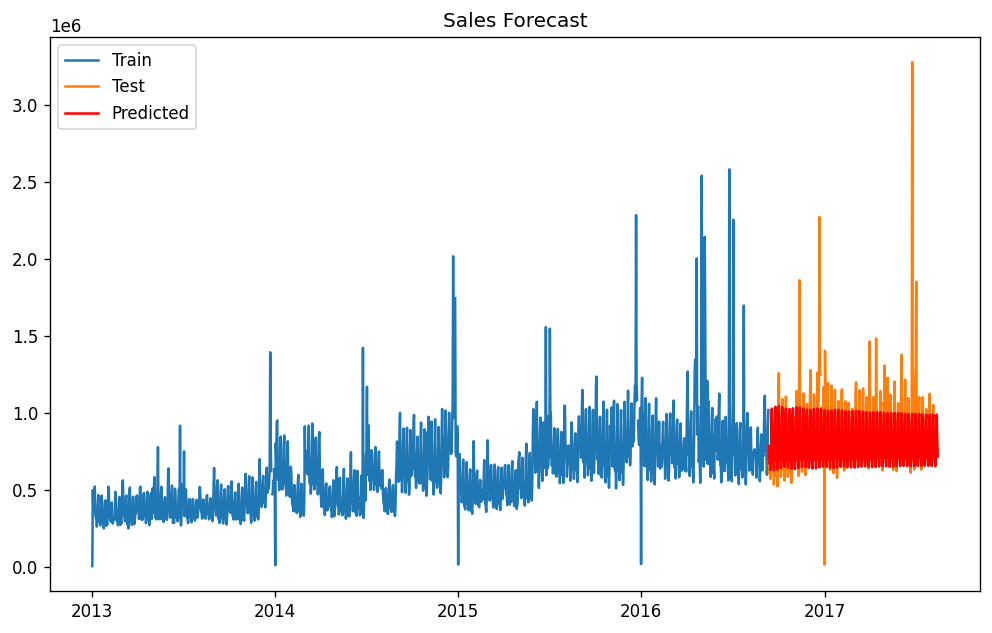

In [378]:
# Forecasting the test set period
start = len(train_arima)
end = len(train_arima) + len(test_arima) - 1

# Forecasting sales
predictions = model_fit.predict(start=start, end=end, typ='levels')

# Plotting actual vs. forecasted values
plt.figure(figsize=(10, 6))
plt.plot(train_arima.index, train_arima['sales'], label='Train')
plt.plot(test_arima.index, test_arima['sales'], label='Test')
plt.plot(test_arima.index, predictions, label='Predicted', color='red')
plt.title('Sales Forecast')
plt.legend()
plt.show()

In [380]:
rmsle = root_mean_squared_log_error(test_arima['sales'].fillna(0), predictions.fillna(0))
print(f'RMSLE: {rmsle}')

RMSLE: 0.8121272047043111


### LSTM (WIP)

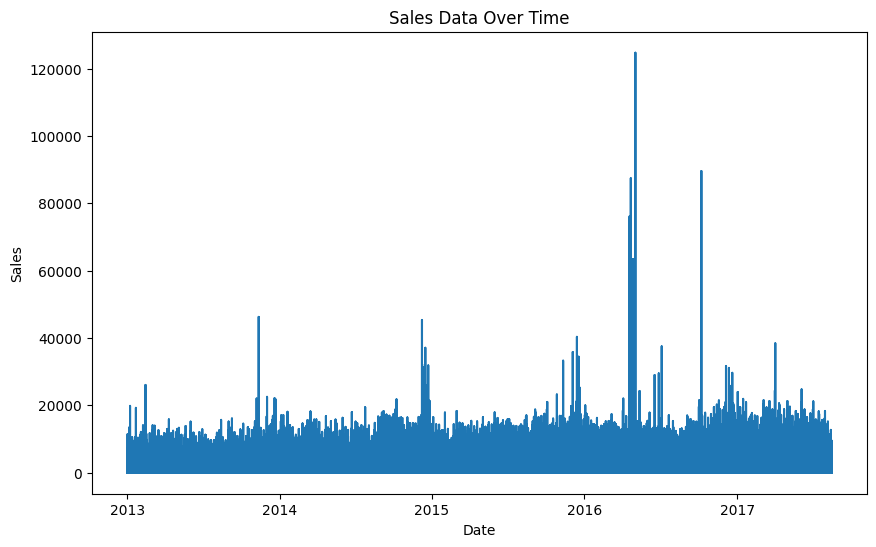

Training data shape: (2443430, 60, 1), (2443430,)
Test data shape: (610858, 60, 1), (610858,)


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Assuming sales_df is your DataFrame
# Make sure the DataFrame is sorted by date
sales_df = sales_df.sort_values('date')

# Visualize the sales data
plt.figure(figsize=(10, 6))
plt.plot(sales_df['date'], sales_df['sales'])
plt.title('Sales Data Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Set the 'date' column as the index
sales_df.set_index('date', inplace=True)

# Scaling the sales data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(sales_df[['sales']])

# Function to create the dataset for LSTM with a look-back period
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 60  # Look-back period (number of previous days to consider)
X, y = create_dataset(scaled_data, look_back)

# Reshape X to be [samples, time steps, features] which is required for LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")


In [48]:
# Building the LSTM model
model = Sequential()

# First LSTM layer with Dropout regularization
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))

# Dense output layer
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_logarithmic_error')

# Summary of the model
model.summary()


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Train the model
model.fit(X_train, y_train, batch_size=64, epochs=1, verbose=1)


38179/38179 ━━━━━━━━━━━━━━━━━━━━ 1171s 31ms/step - loss: 7.0826e-05


In [51]:
# Make predictions on the test set
predictions = model.predict(X_test)

# Inverse transform the predictions and the actual values to get them back to the original scale
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotting the actual vs predicted sales
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual Sales')
plt.plot(predictions, label='Predicted Sales', color='red')
plt.title('LSTM Sales Forecast')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()





 3780/19090 ━━━━━━━━━━━━━━━━━━━━ 1:09 5ms/step

KeyboardInterrupt: 

In [52]:
rmsle = root_mean_squared_log_error(y_test_original, predictions.clip(0.0))
print(f'RMSLE: {rmsle}')

RMSLE: 4.37064424422146


In [ ]:
# Train model
rf_model = RandomForestRegressor(max_depth=300)
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Actual vs. Predicted Contribution Ratios')
plt.xlabel('Actual Contribution Ratio')
plt.ylabel('Predicted Contribution Ratio')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.show()

In [523]:
# Import necessary libraries
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Define a function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Baseline Model: Naive Forecast
# Assume the last observation is the forecast
naive_forecast = train['sales'].iloc[-1]
naive_rmse = calculate_rmse(y_test, [naive_forecast] * len(y_test))
print(f'Naive Forecast RMSE: {naive_rmse}')

# Baseline Model: ARIMA
# Fit an ARIMA model
arima_model = ARIMA(train['sales'], order=(5, 1, 0))
arima_fit = arima_model.fit()

# Forecast using ARIMA
arima_forecast = arima_fit.forecast(steps=len(y_test))
arima_rmse = calculate_rmse(y_test, arima_forecast)
print(f'ARIMA RMSE: {arima_rmse}')

# Advanced Model: XGBoost
from xgboost import XGBRegressor

# Prepare features and target
features = train.drop(columns=['id', 'sales', 'date'])
target = train['sales']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, shuffle=False)

# Train an XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_forecast = xgb_model.predict(X_test)
xgb_rmse = calculate_rmse(y_test, xgb_forecast)
print(f'XGBoost RMSE: {xgb_rmse}')


Naive Forecast RMSE: 15.97276388634846
ARIMA RMSE: 576.3973335958738


ModuleNotFoundError: No module named 'xgboost'